In [1]:
import pandas as pd
import s3fs
from tqdm import tqdm
from joblib import Parallel, delayed
from pathlib import Path
import geopandas as gpd
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import matplotlib.dates as mdates

In [2]:
# This notebook aims to generate the WIT plots after we finish the WIT Airflow DAG (https://github.com/GeoscienceAustralia/dea-airflow/blob/develop/dags/k8s_wit_tooling_conflux.py) running
# Assume we are using follow Airflow config to start Airflow DAG run
airflow_run_cfg = {
"shapefile": "s3://dea-public-data-dev/projects/WIT/test_shp/Ramsar/Ramsar_WIT2_update_UID.shp",
"intermediatedir": "s3://dea-public-data-dev/projects/WIT/bex_ramsar_test_nov2022",
"csvdir": "s3://dea-public-data-dev/projects/WIT/Ramsar_WIT_paper_11_2022",
"cmd": "'lat in [-43.564, -6.292] lon in [87.679, 162.408] gqa_mean_x in [-1, 1]'",
"flags": "--overwrite",
"use_id": "UID"
}

csvdir = airflow_run_cfg['csvdir']
shapefile = airflow_run_cfg['shapefile']

In [3]:
# Setup the AWS S3 access
fs = s3fs.S3FileSystem(anon=True)

# we need load the polygon file to access polygon human-readable information
polygons = gpd.read_file(shapefile)

In [4]:
def load_csv(csv_file_path):
    df = pd.read_csv("s3://" + csv_file_path)
    return df

In [5]:
def normalise_wit(polygon_base_df):
    bands = ['water', 'wet', 'pv', 'npv', 'bs']

    # 1. compute the expected vegetation area total size: 1 - water (%) - wet (%)    
    polygon_base_df["veg_areas"] = 1 - polygon_base_df['water'] - polygon_base_df['wet']
    
    # 2. normalse the vegetation values based on vegetation size (to handle FC values more than 100 issue)
    # WARNNING: Not touch the water and wet, cause they are pixel classification result
    polygon_base_df["overall_veg_num"] = polygon_base_df['pv'] + polygon_base_df['npv'] + polygon_base_df['bs']
    
    # 3. if the overall_veg_num is 0, no need to normalize veg area
    norm_veg_index = polygon_base_df["overall_veg_num"] != 0
    
    for band in bands[2:]:
        polygon_base_df.loc[:, "norm_" + band] = polygon_base_df.loc[:, band]
        polygon_base_df.loc[norm_veg_index, "norm_" + band] = (
            polygon_base_df.loc[norm_veg_index, band]
            / polygon_base_df.loc[norm_veg_index, "overall_veg_num"]
            * polygon_base_df.loc[norm_veg_index, "veg_areas"]
        )

    polygon_base_df.drop(columns=["overall_veg_num", "veg_areas"], inplace=True)
    
    return polygon_base_df

In [6]:
def generate_low_quality_data_periods(df):
    # the generate_low_quality is: SLC off period: https://www.usgs.gov/faqs/what-landsat-7-etm-slc-data
    # and periods with an observation density of less than four observations within a twelve month (365 days) period
    
    # default: all data points are good
    df.loc[:, "off_value"] = 0
    
    # Add the first no-data times (SLC-off only)
    LS5_8_gap_start = datetime.datetime(2011,11,1)
    LS5_8_gap_end = datetime.datetime(2013,4,1)
    
    df.loc[df[(df['date'] >= LS5_8_gap_start) & (df['date'] <= LS5_8_gap_end)].index, "off_value"] = 100
    
    # periods with an observation density of less than four observations within a twelve month (365 days) period
    for i in range(3, len(df) - 3):               
        # can change to another threshold (like: 100 days) to test dyanmic no-data-period display
        if ((df.loc[i + 3, "date"] - df.loc[i, "date"]).days) > 365:
            df.loc[df[(df['date'] >= df.loc[i, "date"]) & (df['date'] <= df.loc[i + 3, "date"])].index, "off_value"] = 100
    
    # print(df[df["off_value"] > 0])
                                                         
    return df

In [7]:
def display_wit_stack_with_df(polygon_base_df, png_name, polygon_name="ANAE_name", width=32, height=6):
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['text.usetex'] = False
    
    fig = plt.figure()
    fig.set_size_inches(width, height)
    ax = fig.add_subplot(111)
    ax.autoscale(enable=True)

    pal = [sns.xkcd_rgb["cobalt blue"],
           sns.xkcd_rgb["neon blue"],
           sns.xkcd_rgb["grass"],
           sns.xkcd_rgb["beige"],
           sns.xkcd_rgb["brown"]]  

    plt.title(f"Percentage of area dominated by WOfS, Wetness, Fractional Cover for\n {polygon_name}", fontsize=16)
    
    ax.stackplot(polygon_base_df["date"], polygon_base_df["water"]*100, polygon_base_df["wet"]*100, polygon_base_df["norm_pv"]*100, polygon_base_df["norm_npv"]*100, polygon_base_df["norm_bs"]*100, colors=pal, alpha=0.7)

    # manually change the legend display order
    legend  = ax.legend(["open water", "wet", "green veg", "dry veg", "bare soil"][::-1], loc='lower left')
    handles = legend.legendHandles
    
    for i, handle in enumerate(handles):
        handle.set_facecolor(pal[::-1][i])
        handle.set_alpha(0.7)
    
    # setup the display ranges
    ax.set_ylim(0, 100)
    ax.set_xlim(polygon_base_df["date"].min(), polygon_base_df["date"].max())
    
    # add a new column: 'off_value' based on low quality data setting
    polygon_base_df = generate_low_quality_data_periods(polygon_base_df)
    
    ax.fill_between(polygon_base_df["date"], 0, 100, where=polygon_base_df["off_value"] == 100, color='white', alpha=0.5, hatch="//")
    
    # modify the xaxis settings
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    x_label_text = "The Fractional Cover algorithm developed by the Joint Remote Sensing Research Program and\n the Water Observations from Space algorithm developed by Geoscience Australia are used in the production of this data"
    
    ax.set_xlabel(x_label_text, style='italic')
    
    plt.savefig(f"{png_name}.png", bbox_inches='tight')
    plt.show()
    
    plt.close(fig)

  0%|          | 0/269 [00:00<?, ?it/s]

Dump PNG to: WIT/0.png


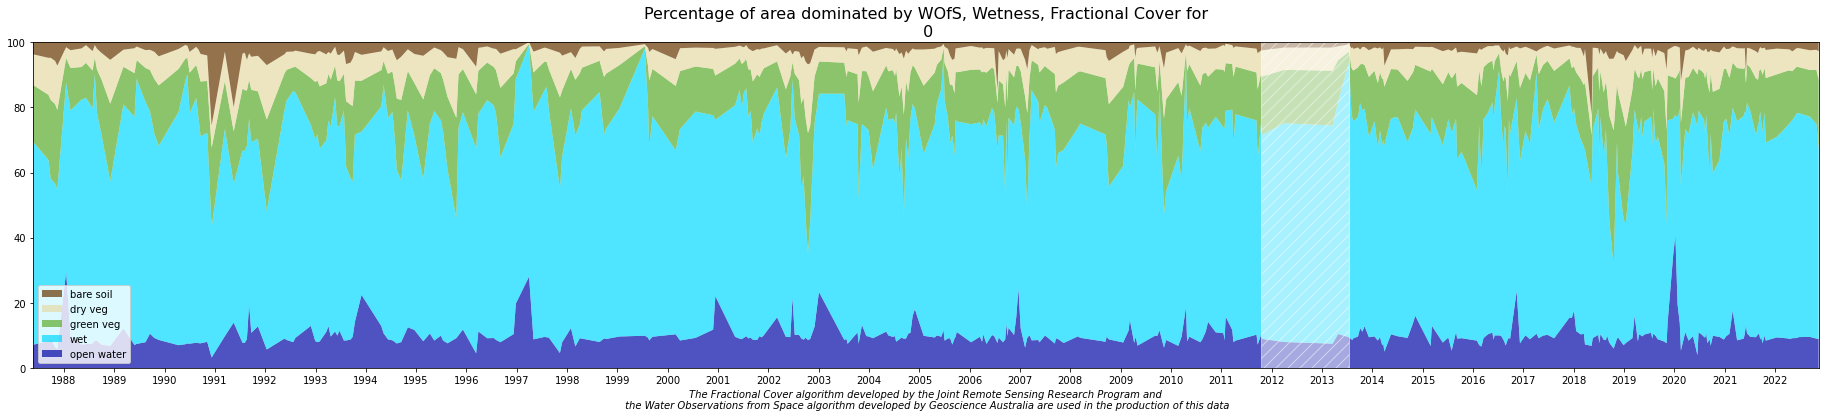

  0%|          | 1/269 [00:00<03:53,  1.15it/s]

Dump PNG to: WIT/1.png


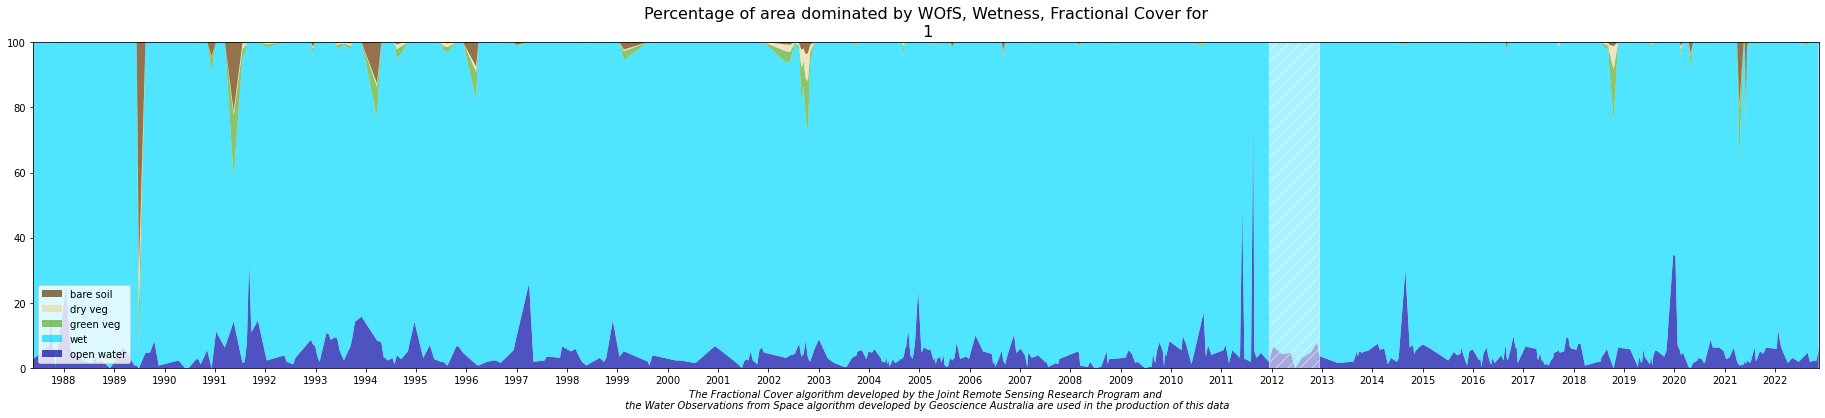

  1%|          | 2/269 [00:01<03:35,  1.24it/s]

Dump PNG to: WIT/10.png


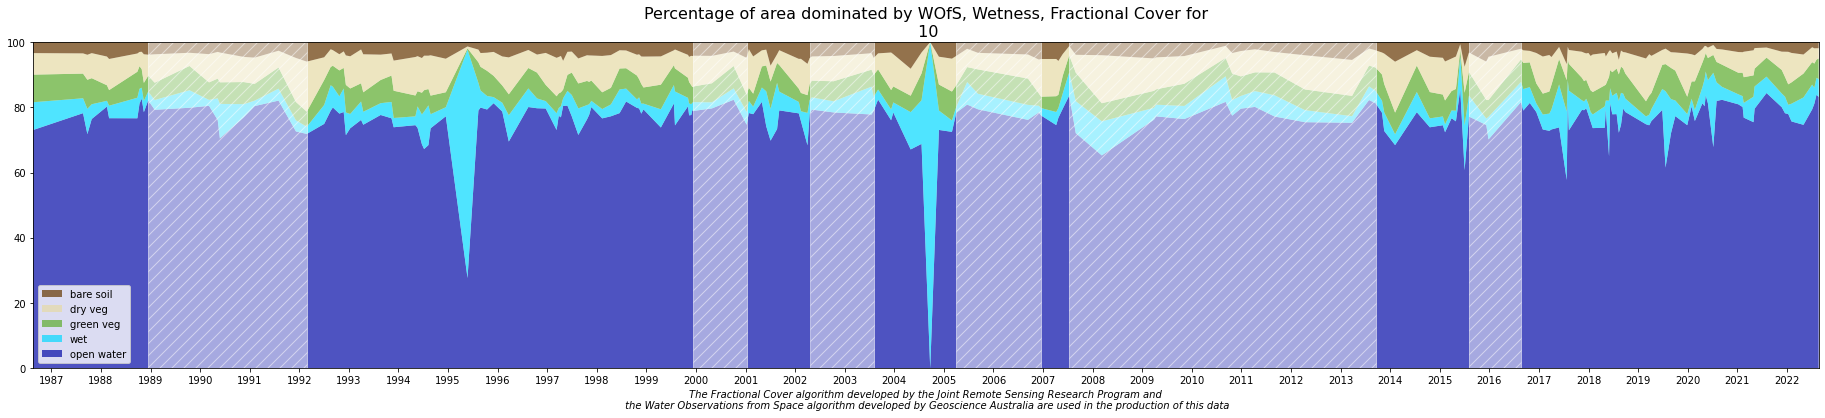

  1%|          | 3/269 [00:02<03:37,  1.22it/s]

Dump PNG to: WIT/100.png


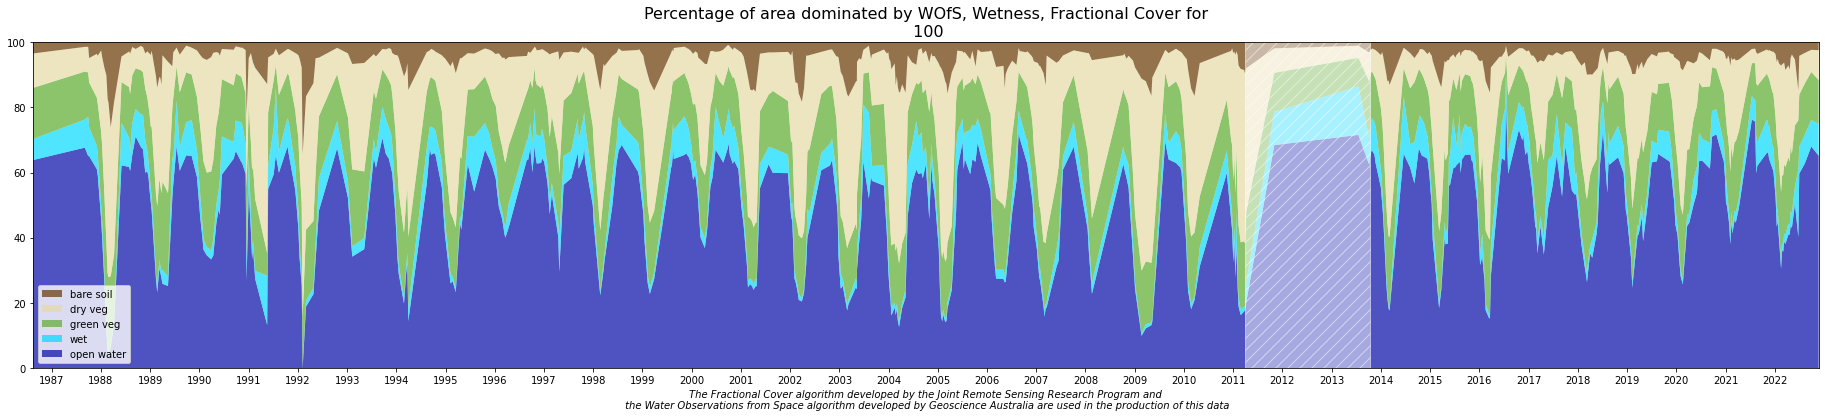

  1%|▏         | 4/269 [00:03<03:36,  1.23it/s]

Dump PNG to: WIT/101.png


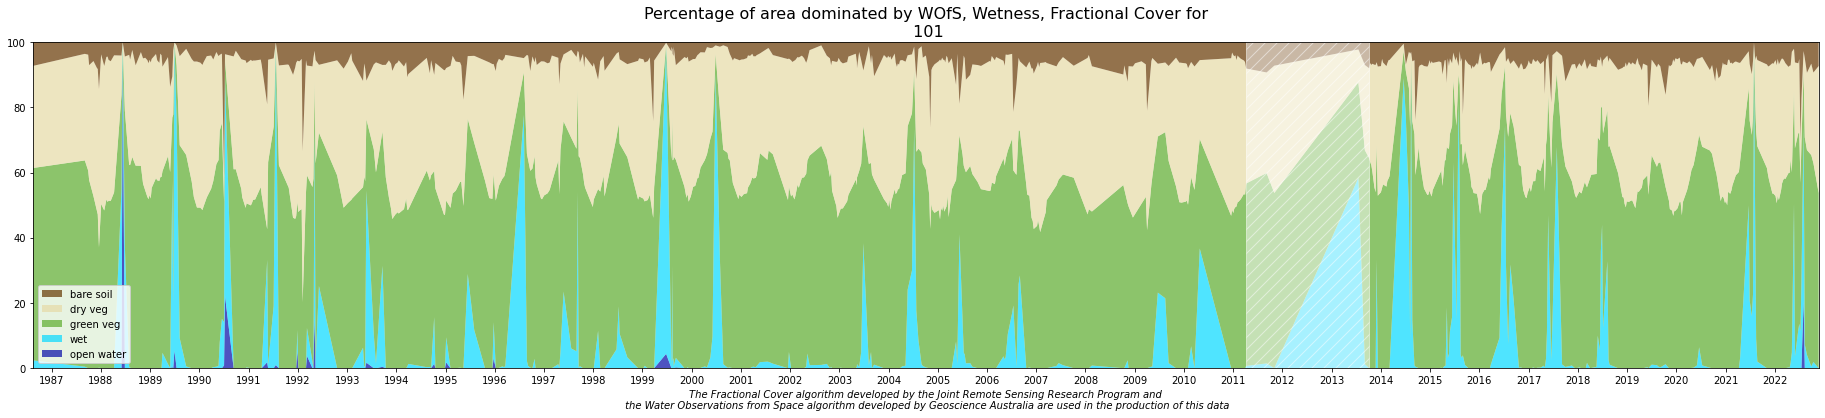

  2%|▏         | 5/269 [00:04<03:34,  1.23it/s]

Dump PNG to: WIT/102.png


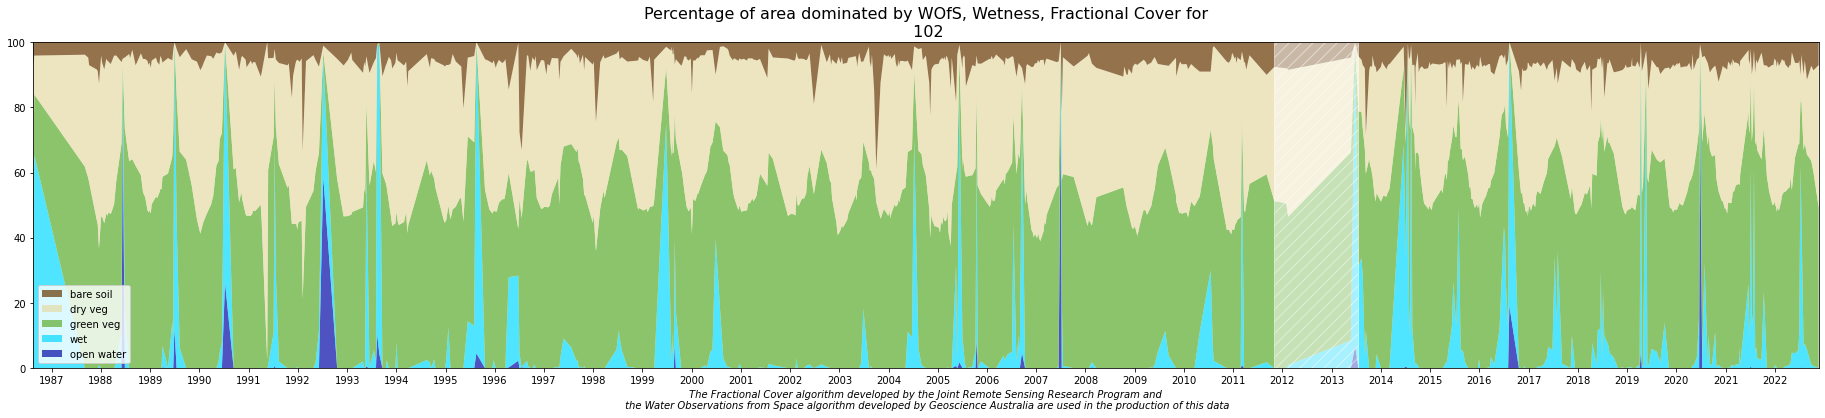

  2%|▏         | 6/269 [00:04<03:33,  1.23it/s]

Dump PNG to: WIT/103.png


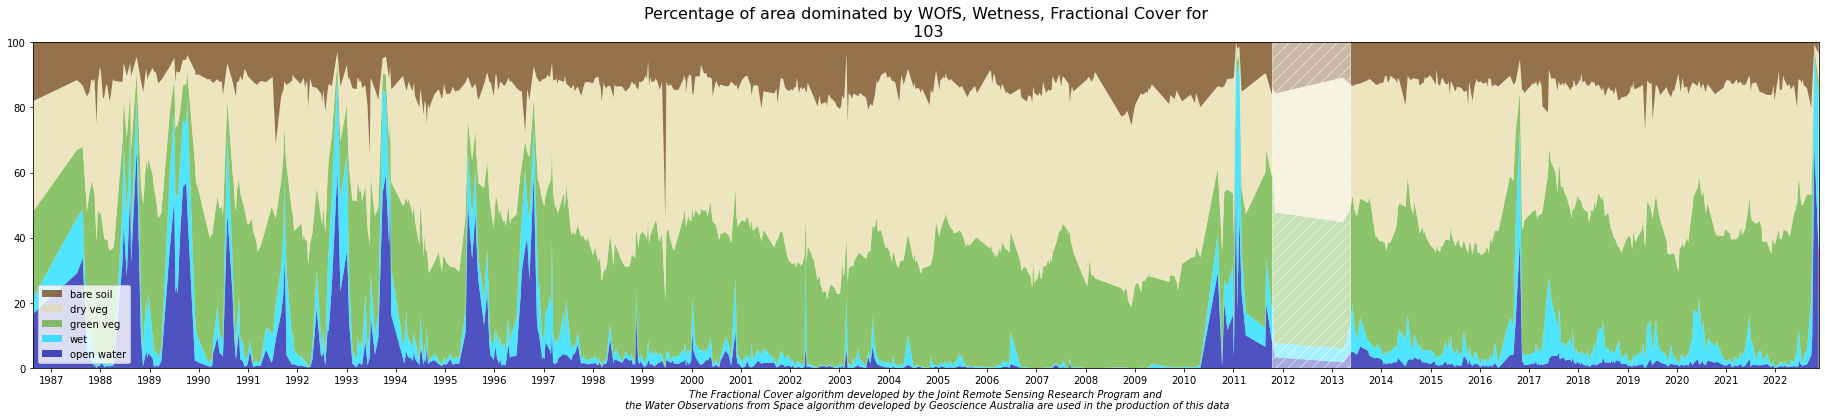

  3%|▎         | 7/269 [00:05<03:30,  1.25it/s]

Dump PNG to: WIT/104.png


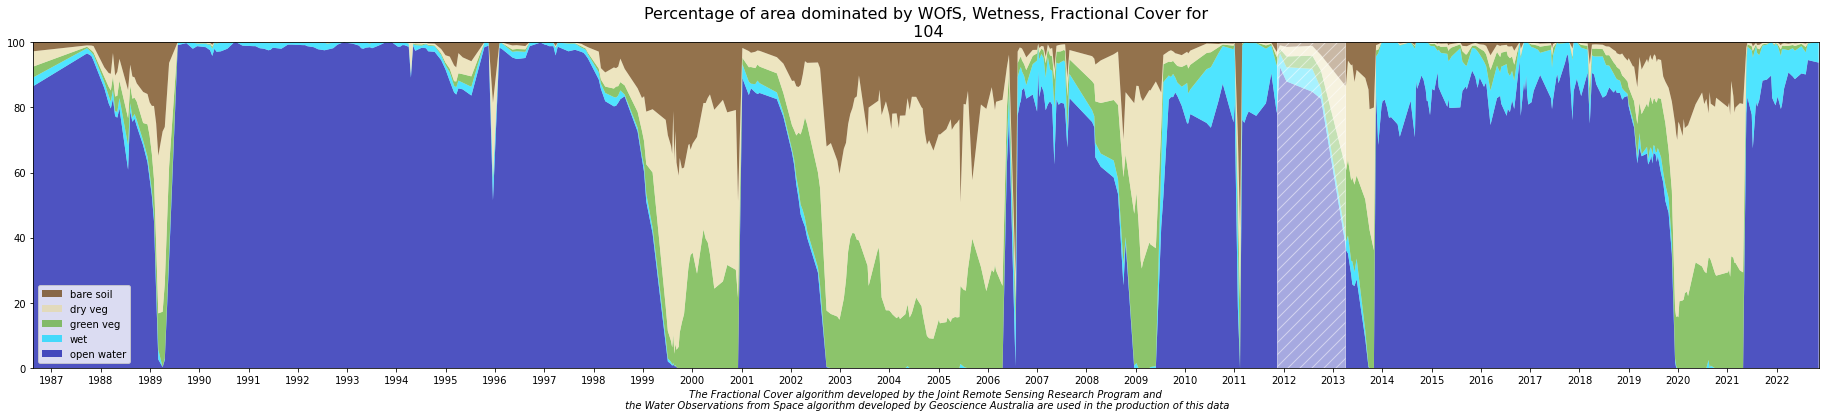

  3%|▎         | 8/269 [00:06<03:32,  1.23it/s]

Dump PNG to: WIT/105.png


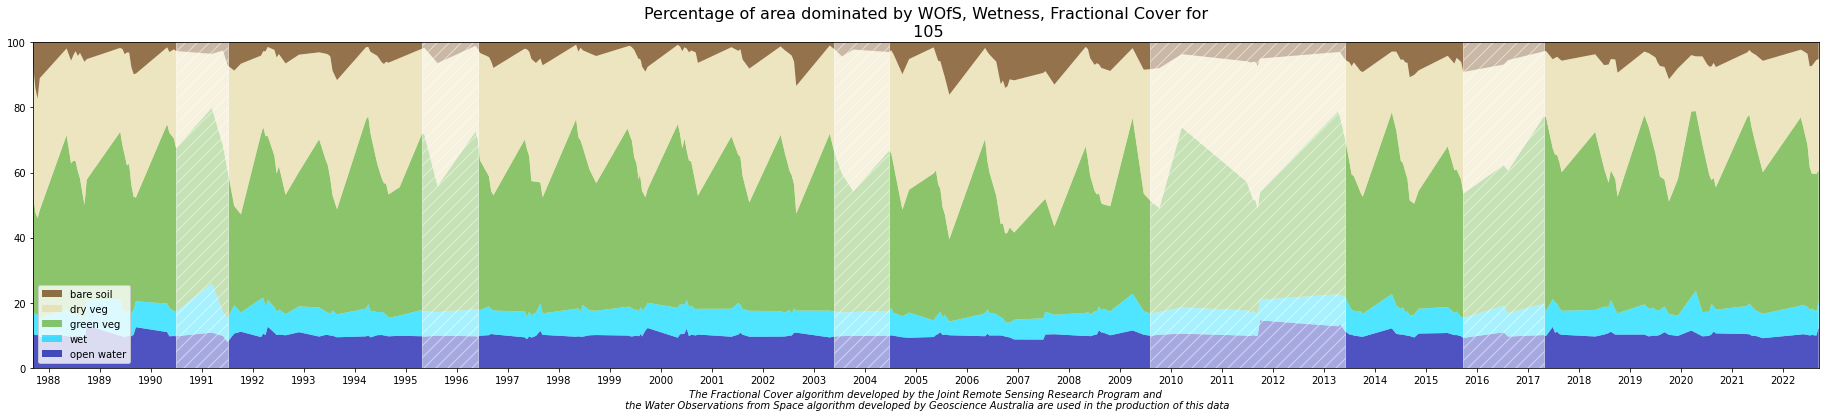

  3%|▎         | 9/269 [00:07<03:30,  1.24it/s]

Dump PNG to: WIT/106.png


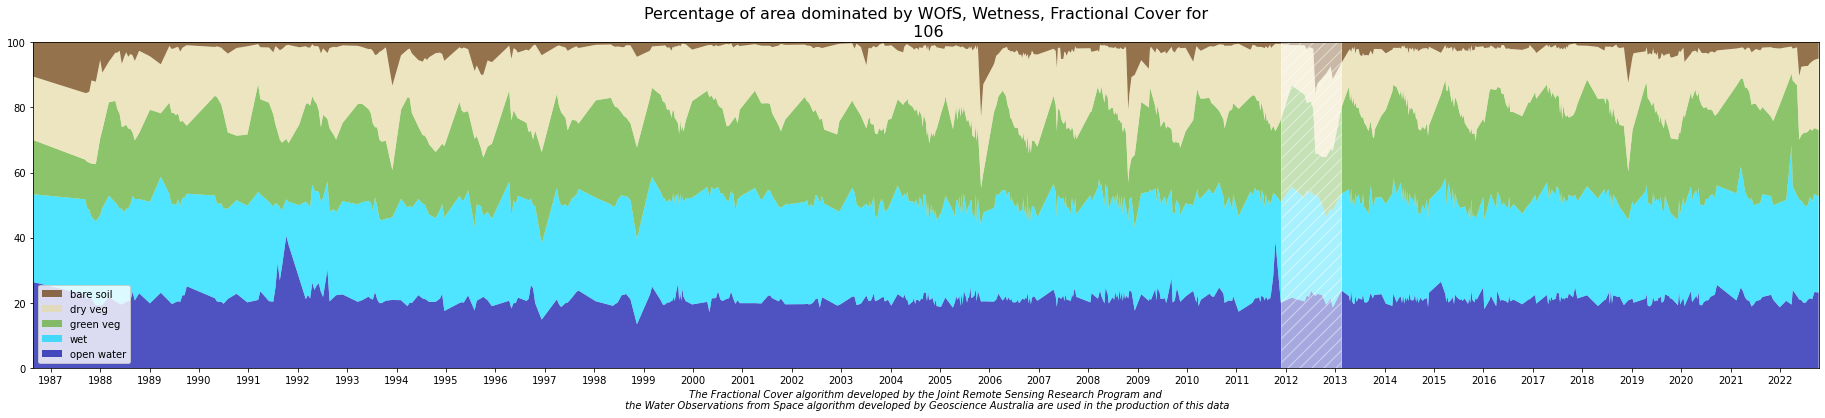

  4%|▎         | 10/269 [00:08<03:24,  1.27it/s]

Dump PNG to: WIT/107.png


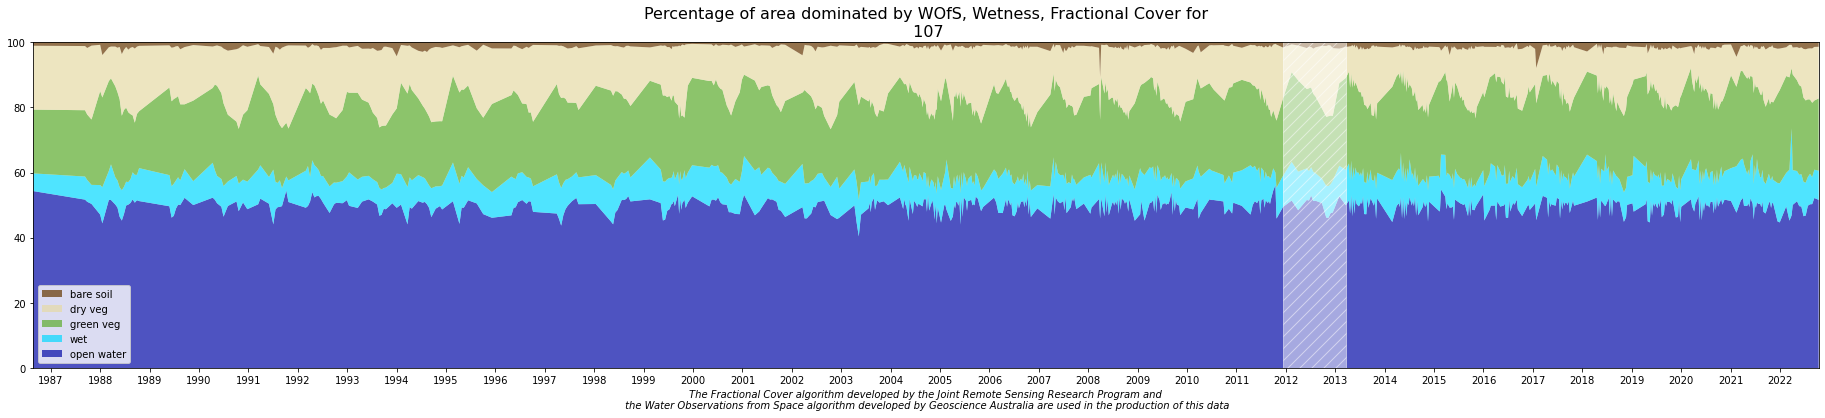

  4%|▍         | 11/269 [00:08<03:21,  1.28it/s]

Dump PNG to: WIT/108.png


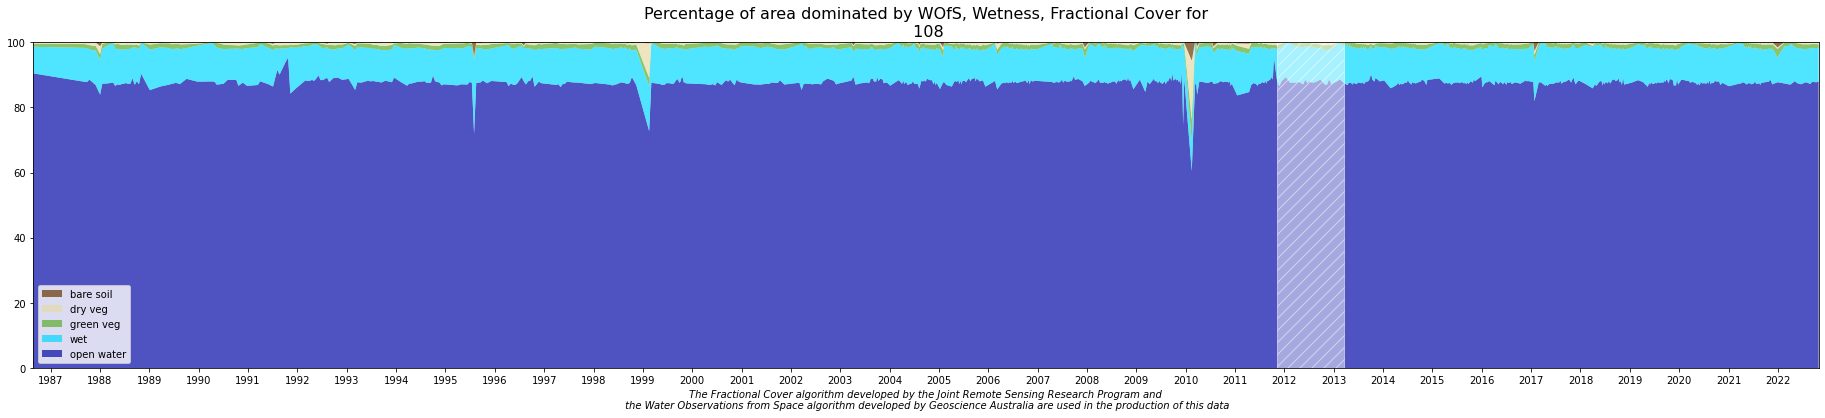

  4%|▍         | 12/269 [00:09<03:19,  1.29it/s]

Dump PNG to: WIT/109.png


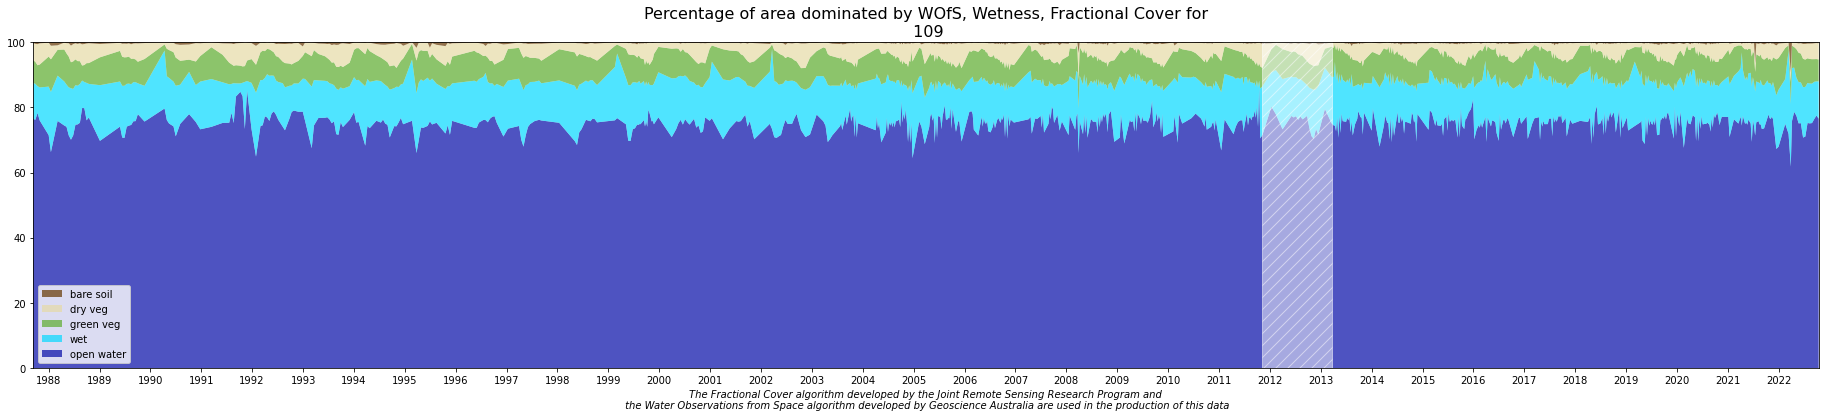

  5%|▍         | 13/269 [00:10<03:17,  1.30it/s]

In [ ]:
# load the WIT result from Airflow DAG running output folder
conflux_c3_csv_files = fs.find(csvdir)

# only get CSV files
conflux_c3_csv_files = [e for e in conflux_c3_csv_files if 'overall' not in e]
conflux_c3_csv_files = [e for e in conflux_c3_csv_files if '.csv' in e]

output_folder = csvdir.split("/")[-2]

import os
os.makedirs(output_folder, exist_ok=True)

for conflux_c3_csv_file in tqdm(conflux_c3_csv_files):
    
    wit_df = load_csv(conflux_c3_csv_file)
    
    if "norm_npv" not in list(wit_df.columns):
        wit_df = normalise_wit(wit_df)
    
    # convert the string to Python datetime format, easy to do display the result in PNG
    wit_df["date"] = pd.to_datetime(wit_df["date"], infer_datetime_format=True)

    # filter by pc_missing and nan
    wit_df = wit_df[wit_df["pc_missing"] < 0.1]
    wit_df = wit_df.dropna(subset=['bs'])
    wit_df.reset_index(inplace=True)
    
    object_name = f"{conflux_c3_csv_file.split('/')[-1]}".replace(".csv", "")
    
    print(f"Dump PNG to: {output_folder}/{object_name}.png")
    
    display_wit_stack_with_df(wit_df, f"{output_folder}/{object_name}", object_name)